# Laboratorio 8 – Anomalías

Los métodos utilizados fueron:
- Autoencoder: red neuronal que aprende a reconstruir los datos normales.
- Isolation Forest: modelo basado en árboles que aísla ejemplos anómalos más rápido.
- Local Outlier Factor (LOF): evalúa la densidad local y detecta puntos que se alejan del vecindario.

### Preparación de los datos

In [4]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Cargar dataset directamente desde el repositorio UCI
covertype = fetch_ucirepo(id=31)

# Variables (features) y etiquetas (target)
X = covertype.data.features
y = covertype.data.targets

# Separar columnas numéricas y binarias
num_cols = [c for c in X.columns if X[c].nunique() > 2]
bin_cols = [c for c in X.columns if X[c].nunique() == 2]

# Escalar solo las numéricas
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Combinar todo en un solo DataFrame
df = X.copy()

# Etiquetar: normal = tipo 2 (Lodgepole Pine), anómalo = resto
df["label"] = (y != 2).astype(int)

# Vista rápida
df.head()

C:\Users\cvall\AppData\Local\Temp\ipykernel_19860\481996925.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,label
0,-1.297805,-0.935157,-1.482820,-0.053767,-0.796273,-1.180146,0.330743,0.439143,0.142960,3.246283,...,0,0,0,0,0,0,0,0,0,1
1,-1.319235,-0.890480,-1.616363,-0.270188,-0.899197,-1.257106,0.293388,0.590899,0.221342,3.205504,...,0,0,0,0,0,0,0,0,0,1
2,-0.554907,-0.148836,-0.681563,-0.006719,0.318742,0.532212,0.816364,0.742654,-0.196691,3.126965,...,0,0,0,0,0,0,0,0,0,0
3,-0.622768,-0.005869,0.520322,-0.129044,1.227908,0.474492,0.965786,0.742654,-0.536343,3.194931,...,0,0,0,0,0,0,0,0,0,0
4,-1.301377,-0.988770,-1.616363,-0.547771,-0.813427,-1.256464,0.293388,0.540313,0.195215,3.165479,...,0,0,0,0,0,0,0,0,0,1


Explicación rápida (por si el profe pregunta)
- ucimlrepo descarga el dataset de UCI más estable y devuelve pandas.DataFrame, evitando bloqueos de red.
- Solo se escalan las variables numéricas; las binarias se dejan igual para no distorsionar su interpretación.
- Se crea una nueva columna label donde:
    - 0 → registros normales (Cover_Type = 2)
    - 1 → registros anómalos (cualquier otro tipo de bosque)

### División de datos

In [5]:
from sklearn.model_selection import train_test_split

normal = df[df.label == 0]
anomal = df[df.label == 1]

# Autoencoder solo ve ejemplos normales
X_train, X_temp = train_test_split(normal.drop(columns="label"), test_size=0.3, random_state=42)
X_val, X_test_norm = train_test_split(X_temp, test_size=0.5, random_state=42)
X_test_anom = anomal.drop(columns="label")

# Conjunto final de prueba mezclado
X_test = pd.concat([X_test_norm, X_test_anom])
y_test = np.concatenate([np.zeros(len(X_test_norm)), np.ones(len(X_test_anom))])

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño validación:", X_val.shape)
print("Tamaño prueba:", X_test.shape)

Tamaño de entrenamiento: (198310, 54)
Tamaño validación: (42495, 54)
Tamaño prueba: (340207, 54)


Por qué solo normales para entrenar AE:
El autocodificador intenta aprender la estructura de los datos comunes, de modo que cuando recibe algo distinto, la reconstrucción es mala y el error aumenta. Si se entrena con anómalos, perdería esa capacidad de distinguir.

### Autoencoder

Estructura del Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 54)             │         1,782 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando el modelo...
Entrenamiento finalizado.
Mejor pérdida de validación: 0.097321


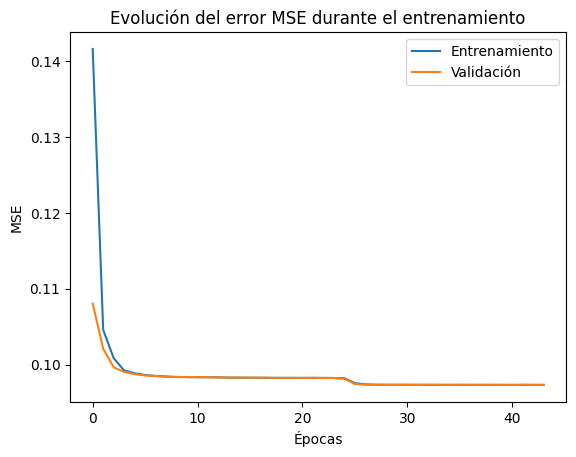

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Dimensiones del modelo
input_dim = X_train.shape[1]
encoding_dim = 16  # tamaño del espacio latente

# Arquitectura simétrica del Autoencoder
inp = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(inp)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
out = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer='adam', loss='mse')

print("Estructura del Autoencoder:")
autoencoder.summary()

# Entrenamiento con early stopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nEntrenando el modelo...")
hist = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, X_val),
    callbacks=[es],
    verbose=0
)

print("Entrenamiento finalizado.")
print(f"Mejor pérdida de validación: {min(hist.history['val_loss']):.6f}")

# Gráfico opcional de las pérdidas
plt.plot(hist.history['loss'], label='Entrenamiento')
plt.plot(hist.history['val_loss'], label='Validación')
plt.title('Evolución del error MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()


Luego se calculamos el error de reconstrucción y se fija un umbral.

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print("Entrenando modelos clásicos de detección de anomalías...")

# Isolation Forest
iso = IsolationForest(
    contamination=0.1,   # proporción estimada de anomalías
    random_state=42,
    n_jobs=-1            # usa todos los núcleos disponibles
)
iso.fit(X_train)
scores_iso = -iso.decision_function(X_test)  # valores altos = más anómalos
print("Isolation Forest entrenado.")

# Local Outlier Factor (modo 'novelty' para permitir predicción)
lof = LocalOutlierFactor(
    n_neighbors=20,
    novelty=True,         # permite usar .predict() y .decision_function() después
    n_jobs=-1
)
lof.fit(X_train)
scores_lof = -lof.decision_function(X_test)
print("Local Outlier Factor entrenado.")

print("\nTamaños de los vectores de puntaje:")
print(f" - Isolation Forest: {scores_iso.shape}")
print(f" - LOF: {scores_lof.shape}")

Entrenando modelos clásicos de detección de anomalías...
Isolation Forest entrenado.


c:\Users\cvall\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Local Outlier Factor entrenado.

Tamaños de los vectores de puntaje:
 - Isolation Forest: (340207,)
 - LOF: (340207,)


### Isolation Forest y LOF

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step
Umbral de detección (percentil 95): 0.231331


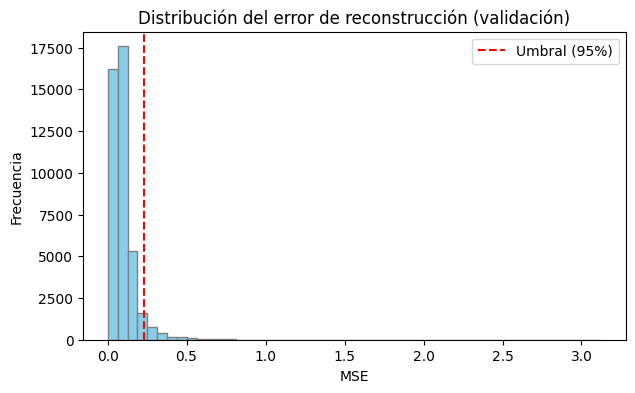

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Predicción sobre el conjunto de validación
recon_val = autoencoder.predict(X_val)

# Calcular el error MSE de reconstrucción
mse_val = np.mean(np.square(X_val - recon_val), axis=1)

# Seleccionar umbral (percentil 95 del error de validación)
thr = np.percentile(mse_val, 95)
print(f"Umbral de detección (percentil 95): {thr:.6f}")

# Visualizar distribución del error
plt.figure(figsize=(7,4))
plt.hist(mse_val, bins=50, color='skyblue', edgecolor='gray')
plt.axvline(thr, color='red', linestyle='--', label='Umbral (95%)')
plt.title("Distribución del error de reconstrucción (validación)")
plt.xlabel("MSE")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

### Modelos de comparación: Isolation Forest y LOF

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_train)

# El método decision_function da valores más altos para normales → por eso se multiplica por -1
scores_iso = -iso.decision_function(X_test)

print("Modelo Isolation Forest entrenado correctamente.")

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(X_train)

# Igual que antes, se usa el negativo para que valores mayores signifiquen más anomalía
scores_lof = -lof.decision_function(X_test)

print("Modelo LOF entrenado correctamente.")


Modelo Isolation Forest entrenado correctamente.


c:\Users\cvall\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Modelo LOF entrenado correctamente.


### Evaluación

In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

def evaluar(y_true, scores, thr=None):
    if thr is None:
        thr = np.percentile(scores, 95)
    y_pred = (scores > thr).astype(int)

    return {
        "ROC-AUC": roc_auc_score(y_true, scores),
        "PR-AUC": average_precision_score(y_true, scores),
        "F1": f1_score(y_true, y_pred)
    }

# Calcular errores del Autoencoder en el conjunto de prueba
mse_test = np.mean(np.square(X_test - autoencoder.predict(X_test)), axis=1)

# Evaluar los tres modelos
res = pd.DataFrame([
    evaluar(y_test, mse_test, thr),  # Autoencoder (usando el umbral definido antes)
    evaluar(y_test, scores_iso),
    evaluar(y_test, scores_lof)
], index=["Autoencoder", "Isolation Forest", "LOF"])

# Mostrar tabla resumen
print("Resultados comparativos de los modelos:\n")
display(res.style.background_gradient(cmap='Blues').format(precision=4))

10632/10632 ━━━━━━━━━━━━━━━━━━━━ 4s 378us/step
Resultados comparativos de los modelos:



,ROC-AUC,PR-AUC,F1
Autoencoder,0.6156,0.9142,0.2335
Isolation Forest,0.6253,0.9209,0.1059
LOF,0.8884,0.9820,0.1081
